## Exploratory Data Analysis (EDA) – HDB Resale Prices, 2015-2024  

This notebook documents the full exploratory workflow behind our final report.  
It is organised as one cell per logical step so that **each block can be re-run independently inside Jupyter**:

1. **Imports & data load** – read the engineered dataset that already carries MRT metrics.  
2. **Missing-value / cardinality audit** – quick table that flags sparsity and one-to-many issues.  
3. **Uniqueness check for spatial columns** – confirms that `latitude`, `longitude`, `address`, `postal`, and `nearest_mrt_distance` identify the same physical location, letting us drop redundant columns later.  
4. **Column type summary** – records raw data types before any transformations.  
5. **Response-by-feature visual sweeps** – box/violin/scatter plots and grouped summaries for every candidate regressor (year, floor-area, lease years, MRT distance, etc.).  
6. **Binning experiments** – coarse groups for floor area and MRT distance to see whether non-linear cut-points exist.  
7. **Categorical comparisons** – town, flat-type, storey-range, expressway distance, number of nearby MRT stations.  
8. **Distribution diagnostics** – histograms, density curves and Q–Q plots for both raw and log resale price.  
9. **Correlation matrix** – Pearson correlations and heat-map for all numeric fields to reveal multicollinearity.  
10. **Street-level pruning** – removes streets with < 100 transactions to avoid high-cardinality dummies later.

All figures are generated with `matplotlib/seaborn`, and grouped numeric summaries are produced with `pandas` and `groupby`.  
The notebook **does not transform or impute data** – it is purely descriptive, so that modelling notebooks start from a clean, immutable CSV.

> **Key takeaway:** the EDA confirms strong right skew in prices, the importance of lease decay, and clear positive premiums for MRT proximity and larger floor areas, validating the feature set used in the regression section of the final report.

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../data/hdb_with_mrt_info.csv")

# Check missing values and unique values for each column
eda_summary = pd.DataFrame({
    "missing_values": df.isna().sum(),
    "unique_values": df.nunique()
})

print(eda_summary)

                          missing_values  unique_values
year                                   0             10
town                                   0             26
flat_type                              0              7
block                                  0           2695
street_name                            0            566
storey_range                           0             17
floor_area_sqm                         0            175
remaining_lease_years                  0             58
resale_price                           0           4232
storey_range_category                  0              5
distance_from_expressway               0              6
latitude                               0           9479
longitude                              0           9479
address                                0           9479
postal                                 0           9479
num_nearby_mrts                        0             12
nearest_mrt                            0        

In [2]:
# Select the relevant columns
subset_df = df[["latitude", "longitude", "address", "postal", "nearest_mrt_distance"]]

# Check how many unique rows there are in the subset
unique_combinations = subset_df.drop_duplicates().shape[0]
print("Number of unique combinations:", unique_combinations)

Number of unique combinations: 9479


We found that features like latitude, longitude, address, postal, nearest_mrt_distance actually have a one-to-one spatial correspondence.
These columns jointly define a location and many columns are actually redundant.

In [ ]:
# Check data type of each column
type_df = pd.DataFrame({
    'column': df.columns,
    'data_type': [df[col].dtype for col in df.columns]
})

print(type_df)

                      column data_type
0                       year     int64
1                       town    object
2                  flat_type    object
3                      block    object
4                street_name    object
5               storey_range    object
6             floor_area_sqm   float64
7      remaining_lease_years     int64
8               resale_price   float64
9      storey_range_category    object
10  distance_from_expressway    object
11                  latitude   float64
12                 longitude   float64
13                   address    object
14                    postal     int64
15           num_nearby_mrts     int64
16               nearest_mrt    object
17      nearest_mrt_distance   float64


### Resale Price by Year (Mean & Median)

The plot of average and median resale prices over time reveals the following patterns:

- **Stable Period (2015–2019):** Both mean and median prices were relatively flat, showing little volatility during this period.
- **Turning Point (2020):** Prices began to rise sharply starting in 2020. This marks a clear shift in the housing market, likely influenced by post-pandemic demand, supply constraints, or macroeconomic conditions.
- **Sustained Growth (2020–2024):** A consistent upward trend is observed in both central tendency measures. The mean resale price crosses the \$600k mark by 2024, while the median follows closely, indicating a broad-based price increase rather than a few high-end outliers.
- **Implication:** The market dynamics after 2020 suggest that time (or year) should be explicitly accounted for in modeling resale prices. Year fixed effects or continuous time trends may be necessary to capture this temporal shift.

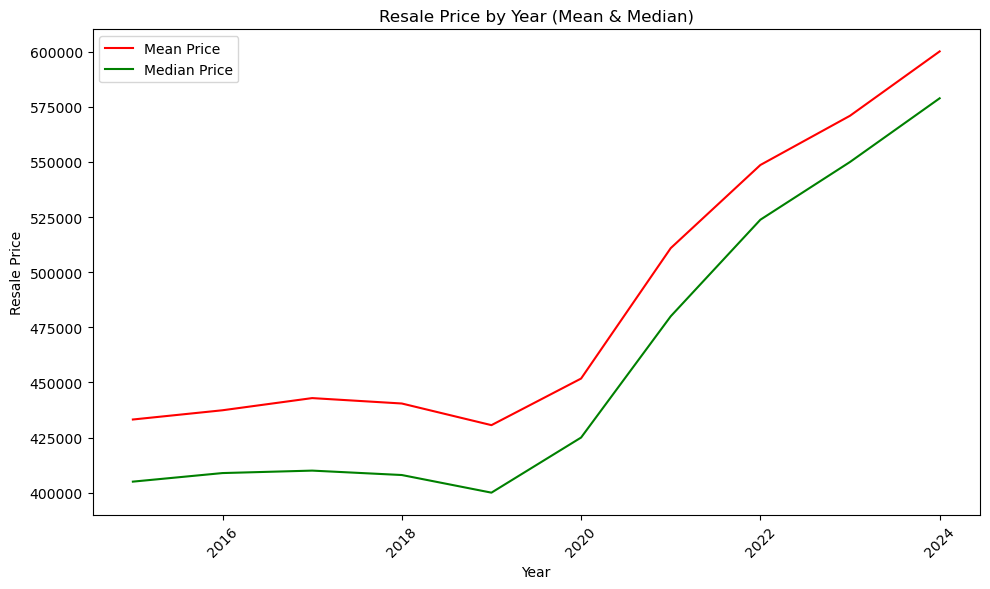

   year  min_price  q1_price  median_price     mean_price  q3_price  \
0  2015   195000.0  340000.0      405000.0  433180.778865  488000.0   
1  2016   190000.0  340000.0      408888.0  437372.686506  495000.0   
2  2017   175000.0  336650.0      410000.0  442891.742850  510000.0   
3  2018   160000.0  328000.0      408000.0  440441.025565  515000.0   
4  2019   150000.0  320000.0      400000.0  430621.183374  505000.0   
5  2020   140000.0  340000.0      425000.0  451758.466403  530000.0   
6  2021   180000.0  398000.0      480000.0  510915.780430  600000.0   
7  2022   200000.0  430000.0      523800.0  548623.821871  640000.0   
8  2023   150000.0  450000.0      550000.0  570964.956714  660000.0   
9  2024   230000.0  470000.0      578888.0  600152.642495  700000.0   

   max_price  count  
0  1088000.0  16933  
1  1120000.0  18401  
2  1180000.0  19314  
3  1185000.0  20517  
4  1205000.0  20977  
5  1258000.0  22055  
6  1360000.0  27500  
7  1418000.0  25399  
8  1480000.0  24311 

In [ ]:
# 1. Calculate mean and median resale prices by year

import seaborn as sns
import matplotlib.pyplot as plt

yearly_stats = df.groupby('year')['resale_price'].agg(['mean', 'median']).reset_index()

# Lineplot of mean and median prices
plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_stats, x='year', y='mean', label='Mean Price', color='red')
sns.lineplot(data=yearly_stats, x='year', y='median', label='Median Price', color='green')
plt.title("Resale Price by Year (Mean & Median)")
plt.xlabel("Year")
plt.ylabel("Resale Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Summary statistics for resale_price by year
summary_year = df.groupby('year')['resale_price'].agg(
    min_price='min',
    q1_price=lambda x: x.quantile(0.25),
    median_price='median',
    mean_price='mean',
    q3_price=lambda x: x.quantile(0.75),
    max_price='max',
    count='count'
).reset_index()

print(summary_year)

### Resale Price by Remaining Lease Years

The plot below illustrates how resale prices vary with the number of remaining lease years on HDB flats, grouped into 5-year bins:

- **Clear Upward Trend:** Both the mean and median resale prices increase steadily as the remaining lease increases, demonstrating a strong positive relationship.
- **Economic Intuition:** This aligns with market expectations—units with longer remaining leases are more attractive to buyers due to better financing options, higher eligibility for CPF grants, and reduced long-term risk.
- **Median ≈ Mean:** The close tracking between the median and mean lines suggests that the price increase is not driven by outliers but reflects a consistent pattern across the market.

This pattern supports the inclusion of non-linear lease age terms (e.g., bins or splines) in any predictive modeling of resale prices.

/var/folders/c2/mhzjxmps67507jxfds7z5g600000gn/T/ipykernel_27286/4190930600.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lease_stats = df.groupby('lease_bin')['resale_price'].agg(['mean', 'median']).reset_index()


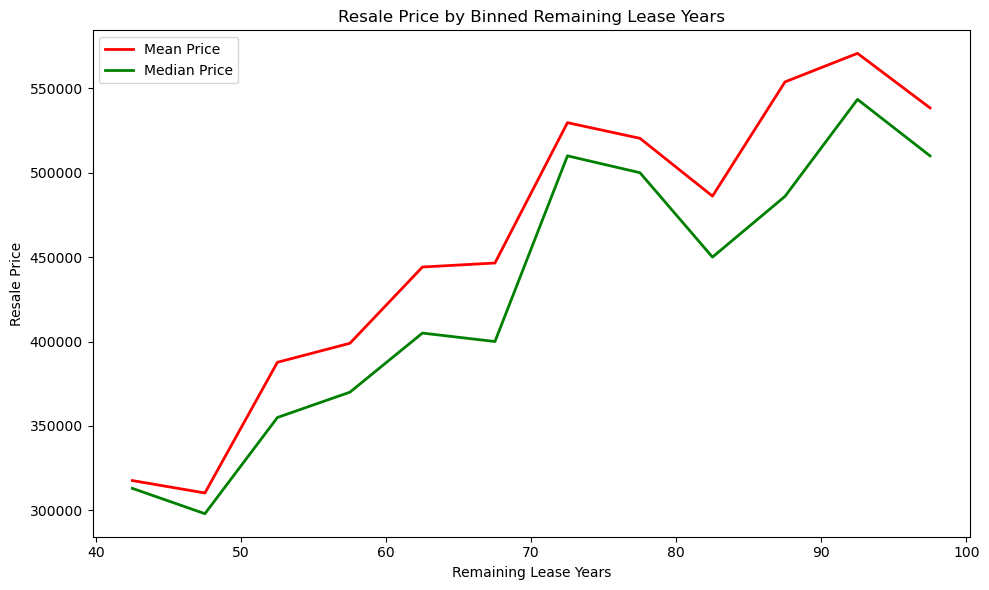

    remaining_lease_years  min_price  q1_price  median_price     mean_price  \
0                      41   315000.0  321250.0      327500.0  327500.000000   
1                      42   250000.0  312500.0      328888.0  339663.200000   
2                      43   230000.0  290000.0      310000.0  314152.882883   
3                      44   235000.0  275800.0      308000.0  310672.129730   
4                      45   205000.0  272000.0      309000.0  318296.544444   
5                      46   165000.0  260000.0      302000.0  310021.501014   
6                      47   178000.0  255375.0      300000.0  308116.542484   
7                      48   160000.0  250000.0      283000.0  297267.303625   
8                      49   150000.0  248000.0      297500.0  318900.187050   
9                      50   140000.0  252000.0      310000.0  347361.590722   
10                     51   175000.0  270000.0      328000.0  366963.942734   
11                     52   160000.0  285000.0      

In [ ]:
# 2. Plot for resale_price by remaining_lease_years
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make 5 years bean - Remaining Lease Years
bin_width = 5
df['lease_bin'] = pd.cut(df['remaining_lease_years'], 
                         bins=range(40, 101, bin_width),  # 40~100
                         right=False, include_lowest=True)

# Calculate mean and median resale prices for each bin
lease_stats = df.groupby('lease_bin')['resale_price'].agg(['mean', 'median']).reset_index()

# Calculate bin midpoints for plotting
lease_stats['bin_mid'] = lease_stats['lease_bin'].apply(lambda x: x.left + bin_width / 2)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=lease_stats, x='bin_mid', y='mean', color='red', label='Mean Price', linewidth=2)
sns.lineplot(data=lease_stats, x='bin_mid', y='median', color='green', label='Median Price', linewidth=2)

plt.title("Resale Price by Binned Remaining Lease Years")
plt.xlabel("Remaining Lease Years")
plt.ylabel("Resale Price")
plt.legend()
plt.tight_layout()
plt.show()


# Summary statistics for resale_price by remaining_lease_years
summary_remaining_lease_years = df.groupby('remaining_lease_years')['resale_price'].agg(
    min_price='min',
    q1_price=lambda x: x.quantile(0.25),
    median_price='median',
    mean_price='mean',
    q3_price=lambda x: x.quantile(0.75),
    max_price='max',
    count='count'
).reset_index()

print(summary_remaining_lease_years)

### Resale Price vs. Floor Area

The scatterplot below visualizes the relationship between floor area (in square meters) and resale price, overlaid with mean and median price trends:

- **Strong Positive Relationship:** Both the mean and median lines show a clear upward trend, affirming the economic intuition that larger units tend to command higher prices.
- **Smooth Trend with Some Variability:** Up to around 200 sqm, the trend is consistently rising. Beyond that, the patterns become more erratic—likely due to small sample sizes in the higher floor area bins.
- **Median ≈ Mean:** The proximity of the mean and median lines indicates that the upward trend is not being distorted by extreme values.

This result supports including floor area as a key structural predictor in modeling housing prices.

/var/folders/c2/mhzjxmps67507jxfds7z5g600000gn/T/ipykernel_27286/4287645482.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  floor_stats = df.groupby('floor_bin')['resale_price'].agg(['mean', 'median']).reset_index()


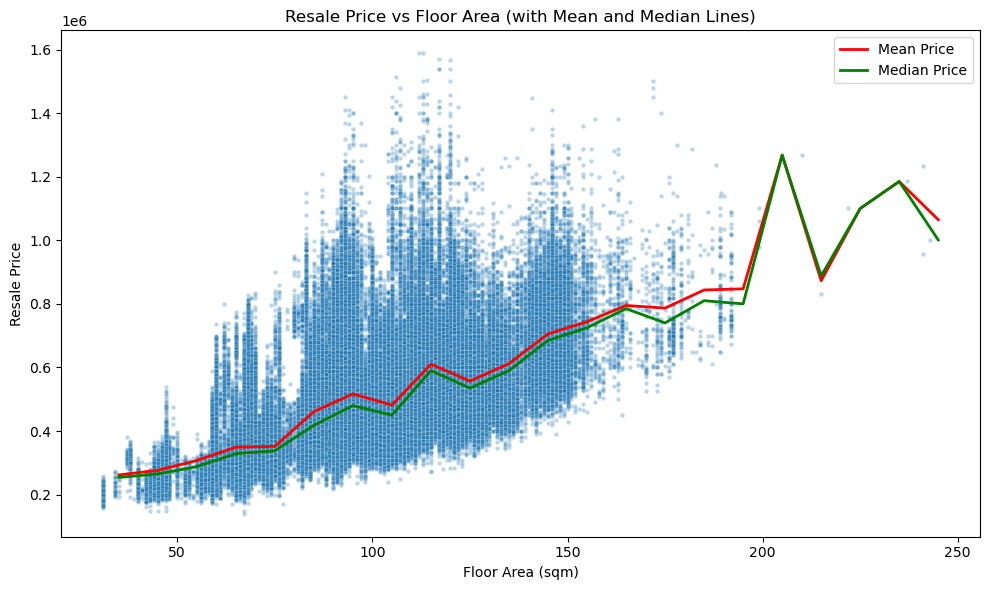

In [ ]:
# 3. Scatterplot with mean and median resale price lines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='floor_area_sqm', y='resale_price', alpha=0.3, s=10)

# # Bin floor area
# bin_width = 10
# df['floor_bin'] = pd.cut(df['floor_area_sqm'], bins=range(0, int(df['floor_area_sqm'].max()) + bin_width, bin_width))

# # Compute mean and median resale prices for each bin
# floor_stats = df.groupby('floor_bin')['resale_price'].agg(['mean', 'median']).reset_index()
# # Compute bin midpoints for plotting
# floor_stats['bin_mid'] = floor_stats['floor_bin'].apply(lambda x: x.left + bin_width / 2)

# # Overlay line plots
# sns.lineplot(data=floor_stats, x='bin_mid', y='mean', color='red', linewidth=2, label='Mean Price')
# sns.lineplot(data=floor_stats, x='bin_mid', y='median', color='green', linewidth=2, label='Median Price')

# plt.title("Resale Price vs Floor Area (with Mean and Median Lines)")
# plt.xlabel("Floor Area (sqm)")
# plt.ylabel("Resale Price")
# plt.legend()
# plt.tight_layout()
# plt.show()


# Remove outliers (e.g., bottom 1% and top 1% of resale_price)
lower = df['resale_price'].quantile(0.01)
upper = df['resale_price'].quantile(0.99)
df_filtered = df[(df['resale_price'] >= lower) & (df['resale_price'] <= upper)]

# Bin floor_area_sqm
floor_min = math.floor(df_filtered['floor_area_sqm'].min())
floor_max = math.ceil(df_filtered['floor_area_sqm'].max())
bin_width = 10
floor_breaks = np.arange(floor_min, floor_max + bin_width, bin_width)

df_filtered['floor_bin'] = pd.cut(df_filtered['floor_area_sqm'], 
                                  bins=floor_breaks, 
                                  right=False, 
                                  include_lowest=True)

# Compute mean and median resale prices per bin
price_stats = df_filtered.groupby('floor_bin')['resale_price'].agg(['mean', 'median']).reset_index()
price_stats['bin_mid'] = price_stats['floor_bin'].apply(lambda x: x.left + bin_width / 2)

# Plot line graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_stats, x='bin_mid', y='mean', color='red', label='Mean Price')
sns.lineplot(data=price_stats, x='bin_mid', y='median', color='green', label='Median Price')
plt.title("Resale Price by Floor Area (with Mean & Median Lines)")
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Resale Price")
plt.legend()
plt.tight_layout()
plt.show()

### Resale Price by Distance to MRT in Selected Towns

To better understand the heterogeneity in the relationship between transit accessibility and resale prices, we stratify the data by town and analyze three representative areas: **Sengkang**, **Pasir Ris**, and the **Central Area**.

- **Sengkang.** A planned residential new town built mostly in the 2000s, Sengkang exhibits minimal variation in MRT distance across HDB units due to its well-integrated LRT system. As shown in the corresponding figure, most resale flats lie within a tight radius of MRT or LRT stations, and resale prices are relatively insensitive to small fluctuations in distance. This reflects the spatial homogeneity of the estate and the success of transit-oriented planning.

- **Pasir Ris.** Located at the northeastern fringe of Singapore, Pasir Ris is served by a single MRT station, making accessibility more variable. The corresponding figure reveals a clearer downward trend in resale prices as the distance from the station increases, affirming that proximity to the sole MRT node drives a stronger price gradient in this town.

- **Central Area.** This urban core is already saturated with MRT, LRT, and alternative transport modes (e.g., taxis, buses). Despite the smaller sample size, the corresponding figure suggests a flat—or possibly upward-sloping—relationship between price and distance to the nearest MRT. This may reflect negative externalities such as noise or congestion associated with flats located too close to major stations.

Together, these results emphasize that the price impact of MRT proximity is **location-dependent**, with stronger effects in fringe or mono-station towns and weaker or even reversed effects in well-connected urban cores.

/var/folders/c2/mhzjxmps67507jxfds7z5g600000gn/T/ipykernel_27286/1181156297.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_stats = df_town.groupby('mrt_bin')['resale_price'].agg(['mean', 'median']).reset_index()


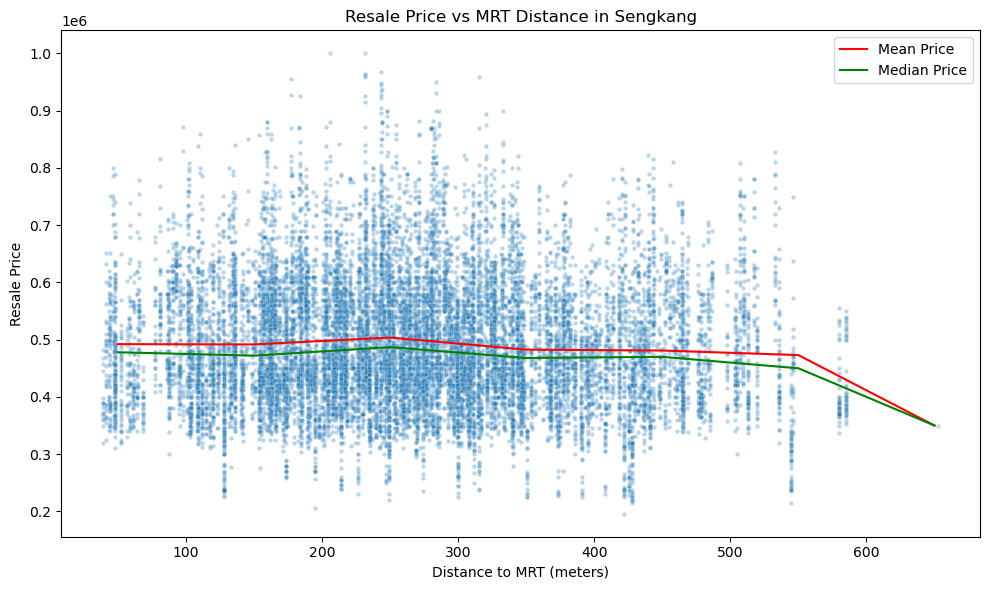

/var/folders/c2/mhzjxmps67507jxfds7z5g600000gn/T/ipykernel_27286/1181156297.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_stats = df_town.groupby('mrt_bin')['resale_price'].agg(['mean', 'median']).reset_index()


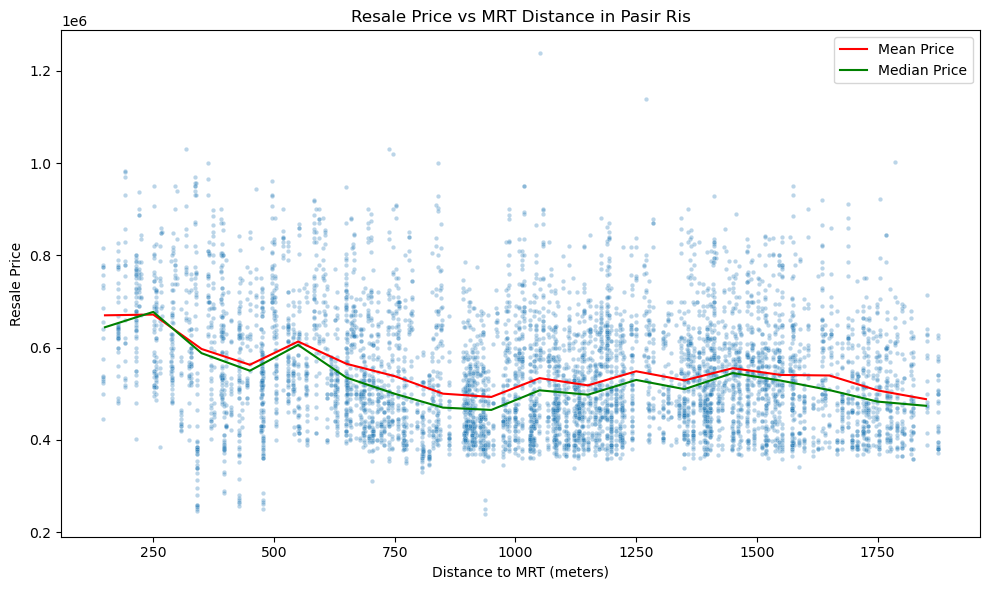

/var/folders/c2/mhzjxmps67507jxfds7z5g600000gn/T/ipykernel_27286/1181156297.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_stats = df_town.groupby('mrt_bin')['resale_price'].agg(['mean', 'median']).reset_index()


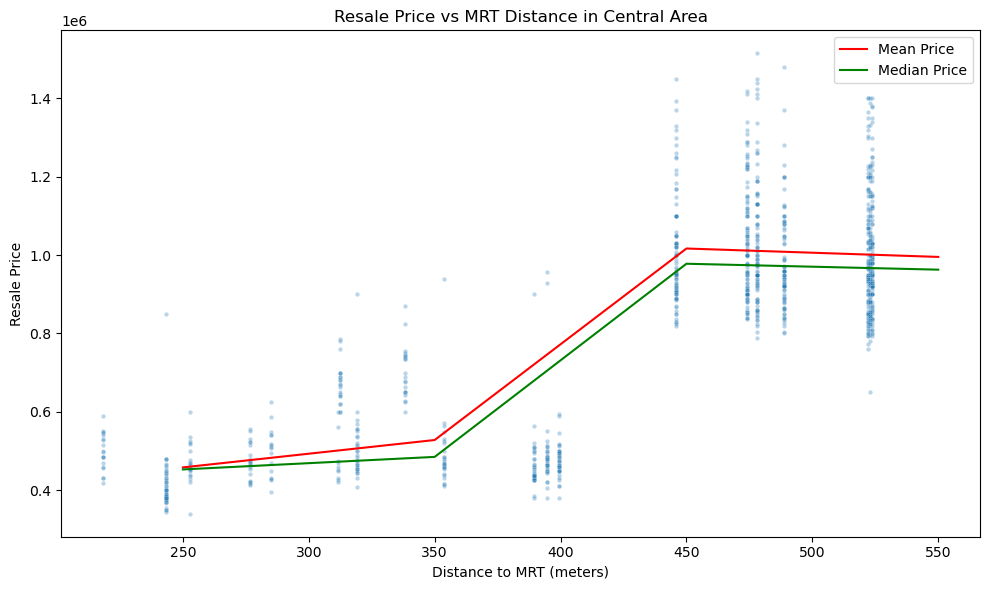

In [ ]:
# 4. Plot for nearest_mrt_distance vs resale_price

# Define towns of interest
selected_towns = ['SENGKANG', 'Pasir Ris', 'Central Area']

# Define distance bin width
bin_width = 100

# Loop over each selected town and plot
for town in selected_towns:
    # Filter data for the town
    df_town = df[df['town'].str.upper() == town.upper()].copy()
    
    # Create bins
    df_town['mrt_bin'] = pd.cut(df_town['nearest_mrt_distance'], 
                                 bins=range(0, int(df_town['nearest_mrt_distance'].max()) + bin_width, bin_width))

    # Compute statistics
    price_stats = df_town.groupby('mrt_bin')['resale_price'].agg(['mean', 'median']).reset_index()
    price_stats['bin_mid'] = price_stats['mrt_bin'].apply(lambda x: x.left + bin_width / 2)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_town, x='nearest_mrt_distance', y='resale_price', alpha=0.3, s=10)
    sns.lineplot(data=price_stats, x='bin_mid', y='mean', color='red', label='Mean Price')
    sns.lineplot(data=price_stats, x='bin_mid', y='median', color='green', label='Median Price')

    plt.title(f"Resale Price vs MRT Distance in {town.title()}")
    plt.xlabel("Distance to MRT (meters)")
    plt.ylabel("Resale Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

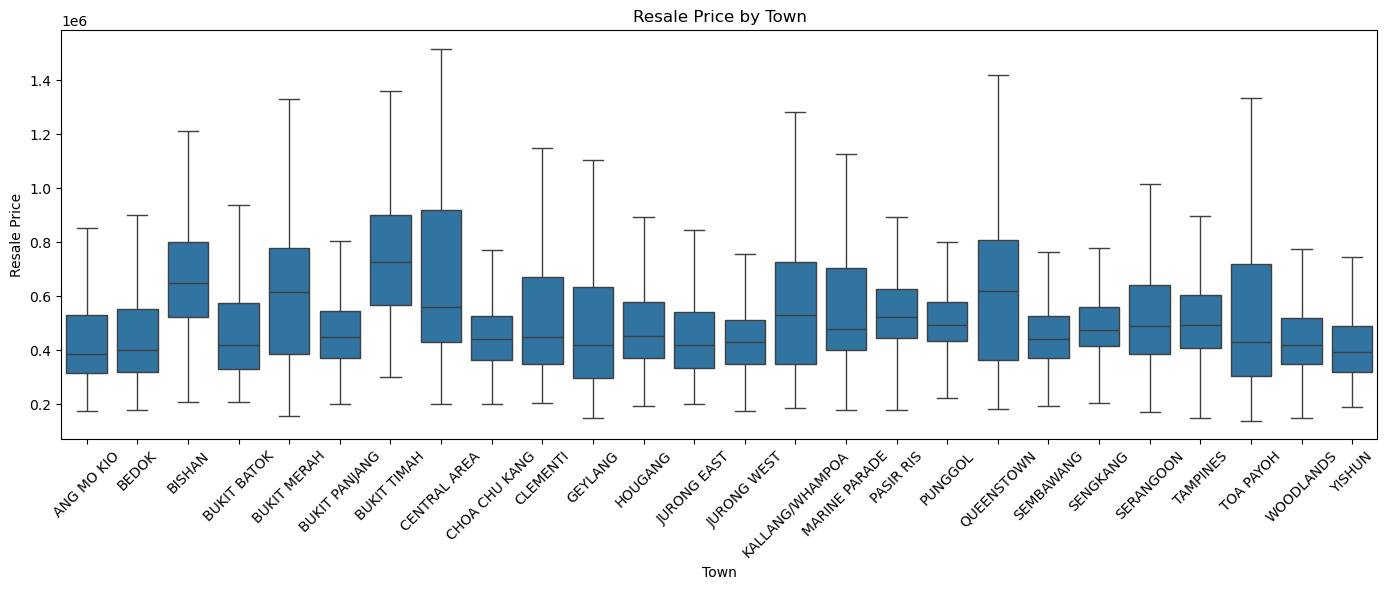

               town  min_price  q1_price  median_price     mean_price  \
0        ANG MO KIO   174000.0  315000.0      385000.0  448673.249362   
1             BEDOK   180000.0  320000.0      400000.0  450093.653171   
2            BISHAN   210000.0  525000.0      650000.0  669547.740101   
3       BUKIT BATOK   208000.0  330000.0      420000.0  459839.839956   
4       BUKIT MERAH   157000.0  385000.0      616000.0  602913.466496   
5     BUKIT PANJANG   200000.0  370000.0      450000.0  466741.788078   
6       BUKIT TIMAH   300000.0  566500.0      725000.0  742855.433539   
7      CENTRAL AREA   200000.0  432000.0      560000.0  666921.926934   
8     CHOA CHU KANG   200000.0  365000.0      443000.0  454671.159078   
9          CLEMENTI   205000.0  350000.0      450000.0  516812.516910   
10          GEYLANG   150000.0  298000.0      418000.0  472574.886246   
11          HOUGANG   195000.0  370000.0      453888.0  485037.252759   
12      JURONG EAST   200000.0  335000.0      42000

In [ ]:
# 5. Resale price by town
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='town', y='resale_price', showfliers=False)
plt.title("Resale Price by Town")
plt.xlabel("Town")
plt.ylabel("Resale Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary statistics for town
summary_town = df.groupby("town").agg(
    min_price=("resale_price", "min"),
    q1_price=("resale_price", lambda x: np.percentile(x.dropna(), 25)),
    median_price=("resale_price", "median"),
    mean_price=("resale_price", "mean"),
    q3_price=("resale_price", lambda x: np.percentile(x.dropna(), 75)),
    max_price=("resale_price", "max"),
    count=("resale_price", "count")
).reset_index()

print(summary_town)

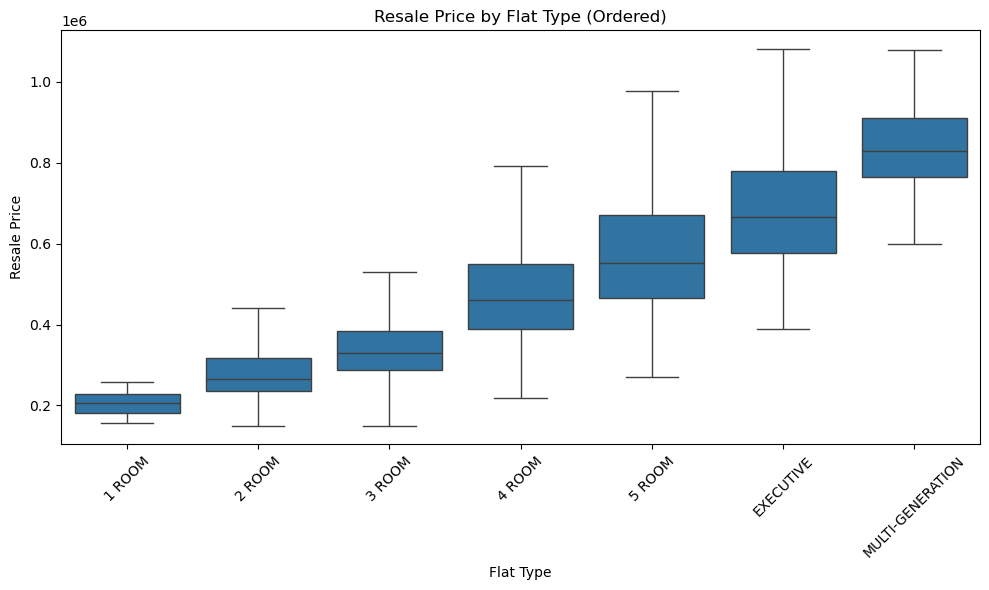

          flat_type  min_price  q1_price  median_price     mean_price  \
0            1 ROOM   157000.0  180500.0      205000.0  204353.459459   
1            2 ROOM   150000.0  235000.0      266444.0  276215.323626   
2            3 ROOM   140000.0  288000.0      330000.0  347885.521467   
3            4 ROOM   218000.0  390000.0      460000.0  490912.365030   
4            5 ROOM   270000.0  465000.0      553000.0  585234.019374   
5         EXECUTIVE   390000.0  578000.0      666888.0  687866.268390   
6  MULTI-GENERATION   600000.0  765000.0      830000.0  836419.012346   

   q3_price  max_price  count  
0  228750.0   258000.0     74  
1  318000.0   585000.0   3640  
2  385000.0  1568000.0  52953  
3  550888.0  1500000.0  91641  
4  670000.0  1588000.0  53769  
5  780000.0  1500000.0  16308  
6  910000.0  1200000.0     81  


/var/folders/c2/mhzjxmps67507jxfds7z5g600000gn/T/ipykernel_27286/3775873996.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_flat_type = df.groupby("flat_type").agg(


In [ ]:
# 6. Boxplot for flat_type
flat_type_order = ["1 ROOM", "2 ROOM", "3 ROOM", "4 ROOM", "5 ROOM", "EXECUTIVE", "MULTI-GENERATION"]
df['flat_type'] = pd.Categorical(df['flat_type'], categories=flat_type_order, ordered=True)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='flat_type', y='resale_price', showfliers=False)
plt.title("Resale Price by Flat Type (Ordered)")
plt.xlabel("Flat Type")
plt.ylabel("Resale Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary statistics for flat_type
summary_flat_type = df.groupby("flat_type").agg(
    min_price=("resale_price", "min"),
    q1_price=("resale_price", lambda x: np.percentile(x.dropna(), 25)),
    median_price=("resale_price", "median"),
    mean_price=("resale_price", "mean"),
    q3_price=("resale_price", lambda x: np.percentile(x.dropna(), 75)),
    max_price=("resale_price", "max"),
    count=("resale_price", "count")
).reset_index()

print(summary_flat_type)

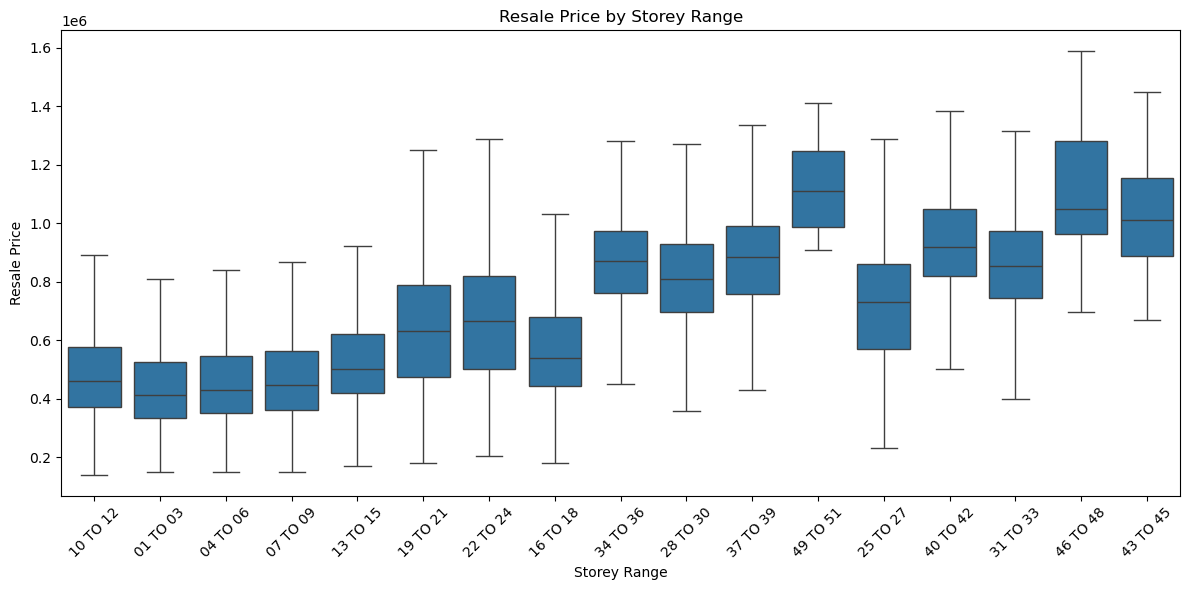

   storey_range  min_price  q1_price  median_price    mean_price   q3_price  \
0      01 TO 03   150000.0  335000.0      412000.0  4.434140e+05   525000.0   
1      04 TO 06   150000.0  350000.0      430000.0  4.618324e+05   546000.0   
2      07 TO 09   150000.0  360000.0      448000.0  4.749381e+05   562888.0   
3      10 TO 12   140000.0  370000.0      460000.0  4.873375e+05   578000.0   
4      13 TO 15   170000.0  418000.0      500000.0  5.276369e+05   620000.0   
5      16 TO 18   180100.0  443000.0      540000.0  5.711583e+05   680000.0   
6      19 TO 21   180000.0  475000.0      630000.0  6.397304e+05   788000.0   
7      22 TO 24   205000.0  503000.0      665000.0  6.699910e+05   818000.0   
8      25 TO 27   230000.0  570000.0      730000.0  7.197723e+05   860000.0   
9      28 TO 30   150000.0  697500.0      810088.0  8.035303e+05   930000.0   
10     31 TO 33   325000.0  745000.0      855000.0  8.529384e+05   975000.0   
11     34 TO 36   355000.0  760000.0      870088.0  

In [ ]:
# 7. Boxplot for storey_range
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='storey_range', y='resale_price', showfliers=False)
plt.title("Resale Price by Storey Range")
plt.xlabel("Storey Range")
plt.ylabel("Resale Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary statistics for storey_range
summary_storey_range = df.groupby("storey_range").agg(
    min_price=("resale_price", "min"),
    q1_price=("resale_price", lambda x: np.percentile(x.dropna(), 25)),
    median_price=("resale_price", "median"),
    mean_price=("resale_price", "mean"),
    q3_price=("resale_price", lambda x: np.percentile(x.dropna(), 75)),
    max_price=("resale_price", "max"),
    count=("resale_price", "count")
).reset_index()

print(summary_storey_range)

/var/folders/c2/mhzjxmps67507jxfds7z5g600000gn/T/ipykernel_27286/3314441897.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = df.groupby('distance_from_expressway')['resale_price'].agg(['mean', 'median']).reset_index()


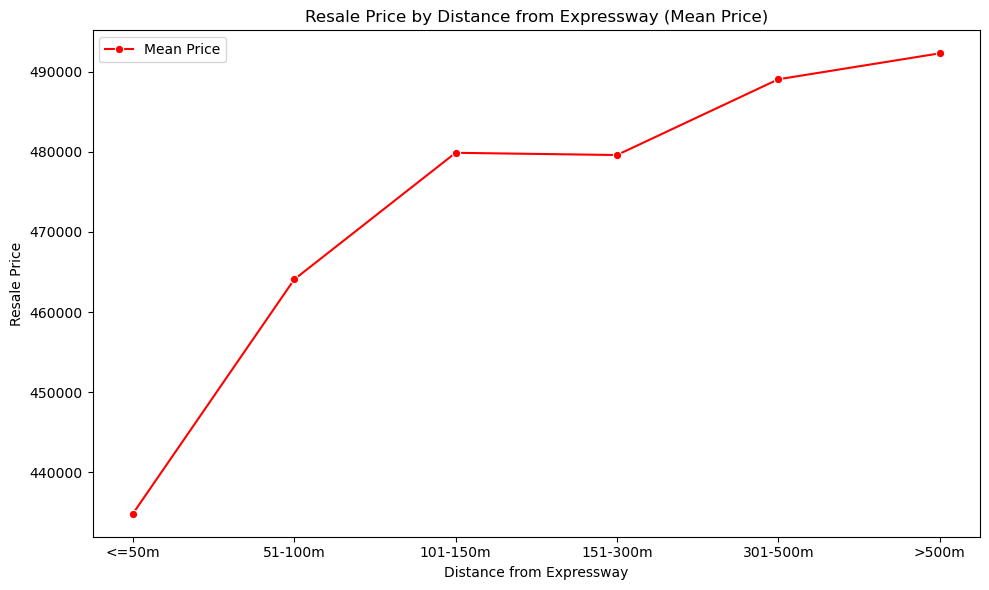

  distance_from_expressway  min_price  q1_price  median_price     mean_price  \
0                    <=50m   172000.0  330000.0      415000.0  434838.739667   
1                  51-100m   157000.0  345000.0      445000.0  464078.067479   
2                 101-150m   176000.0  355000.0      450000.0  479882.368482   
3                 151-300m   185000.0  338000.0      432000.0  479605.014123   
4                 301-500m   180000.0  350000.0      443444.0  489058.211735   
5                    >500m   140000.0  368000.0      460000.0  492295.675823   

   q3_price  max_price   count  
0  515000.0  1380000.0    3484  
1  558000.0  1230000.0    8386  
2  570000.0  1300000.0    6079  
3  585000.0  1410000.0    7347  
4  580000.0  1400000.0    3688  
5  585000.0  1588000.0  182600  


/var/folders/c2/mhzjxmps67507jxfds7z5g600000gn/T/ipykernel_27286/3314441897.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_distance_from_expressway = df.groupby("distance_from_expressway").agg(


In [39]:
# 8. Plot for distance_from_expressway
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the desired order
ordered_categories = ['<=50m', '51-100m', '101-150m', '151-300m', '301-500m', '>500m']

# Ensure the column is a categorical type with the right order
df['distance_from_expressway'] = pd.Categorical(df['distance_from_expressway'], categories=ordered_categories, ordered=True)

# Group and compute statistics
stats = df.groupby('distance_from_expressway')['resale_price'].agg(['mean', 'median']).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=stats, x='distance_from_expressway', y='mean', label='Mean Price', color='red', marker='o')
# sns.lineplot(data=stats, x='distance_from_expressway', y='median', label='Median Price', color='green', marker='o')

plt.title("Resale Price by Distance from Expressway (Mean Price)")
plt.xlabel("Distance from Expressway")
plt.ylabel("Resale Price")
plt.tight_layout()
plt.legend()
plt.show()


# Summary statistics for distance_from_expressway
summary_distance_from_expressway = df.groupby("distance_from_expressway").agg(
    min_price=("resale_price", "min"),
    q1_price=("resale_price", lambda x: np.percentile(x.dropna(), 25)),
    median_price=("resale_price", "median"),
    mean_price=("resale_price", "mean"),
    q3_price=("resale_price", lambda x: np.percentile(x.dropna(), 75)),
    max_price=("resale_price", "max"),
    count=("resale_price", "count")
).reset_index()

print(summary_distance_from_expressway)

# df["distance_from_expressway"].unique()

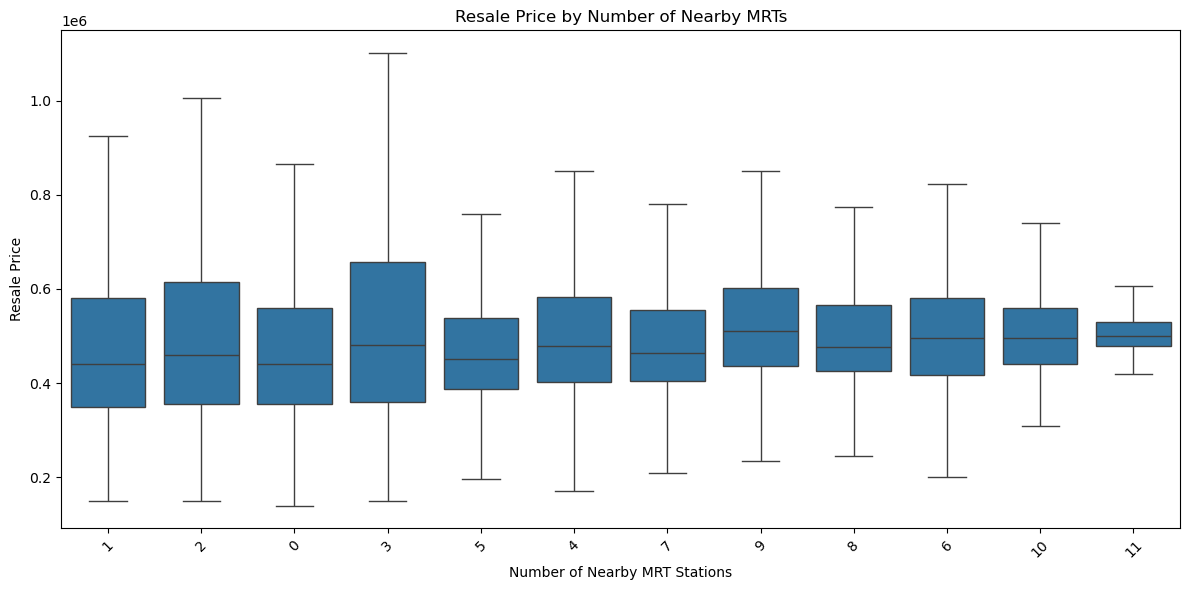

    num_nearby_mrts  min_price  q1_price  median_price     mean_price  \
0                 0   140000.0  356000.0      440000.0  468760.194193   
1                 1   150000.0  350000.0      440000.0  480928.990473   
2                 2   150000.0  355000.0      460000.0  503307.611951   
3                 3   150000.0  360000.0      482000.0  526885.364297   
4                 4   172000.0  402888.0      478000.0  514788.854157   
5                 5   196000.0  388000.0      452000.0  466950.616520   
6                 6   200000.0  418000.0      495000.0  504073.568644   
7                 7   210000.0  405000.0      463888.0  484934.315803   
8                 8   245000.0  425000.0      477500.0  500184.925596   
9                 9   235000.0  436916.0      510000.0  525049.389089   
10               10   310000.0  440000.0      494944.0  507646.623444   
11               11   380000.0  478000.0      500000.0  517147.971631   

    q3_price  max_price  count  
0   560000.0  156

In [ ]:
# 9. Boxplot for number of nearby MRT stations
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x=df["num_nearby_mrts"].astype(str), y="resale_price", showfliers=False)
plt.title("Resale Price by Number of Nearby MRTs")
plt.xlabel("Number of Nearby MRT Stations")
plt.ylabel("Resale Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary statistics for num_nearby_mrts
summary_num_nearby_mrts = df.groupby("num_nearby_mrts").agg(
    min_price=("resale_price", "min"),
    q1_price=("resale_price", lambda x: np.percentile(x.dropna(), 25)),
    median_price=("resale_price", "median"),
    mean_price=("resale_price", "mean"),
    q3_price=("resale_price", lambda x: np.percentile(x.dropna(), 75)),
    max_price=("resale_price", "max"),
    count=("resale_price", "count")
).reset_index()

print(summary_num_nearby_mrts)

#### General Observations

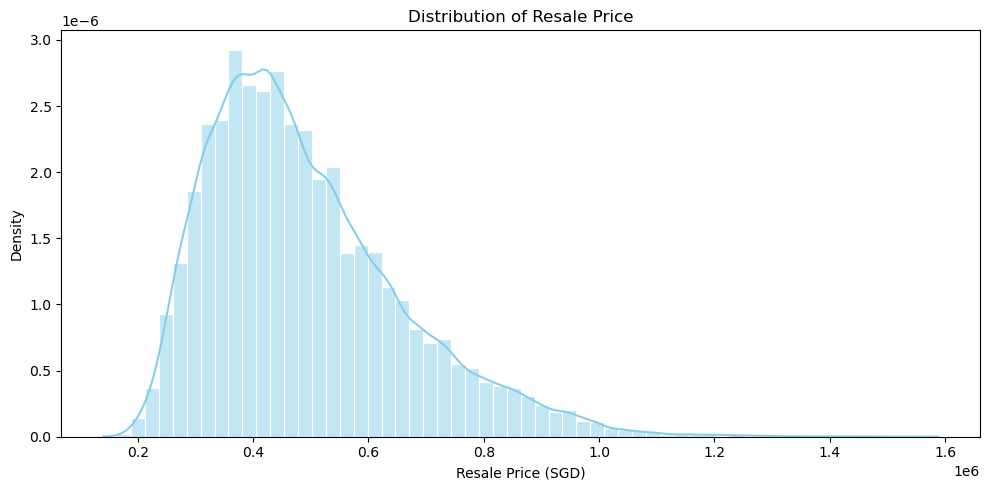

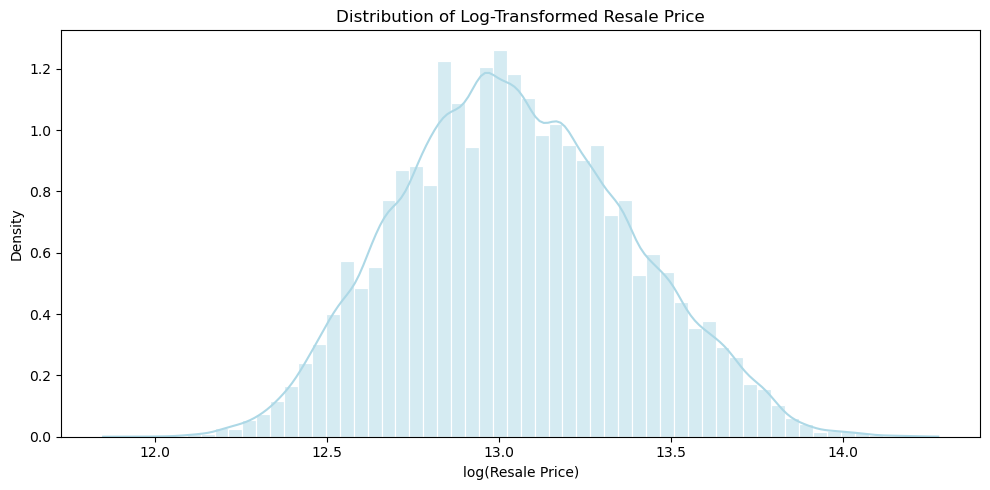

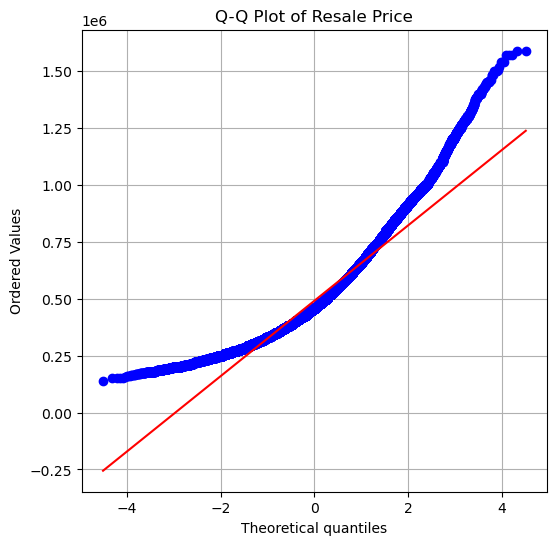

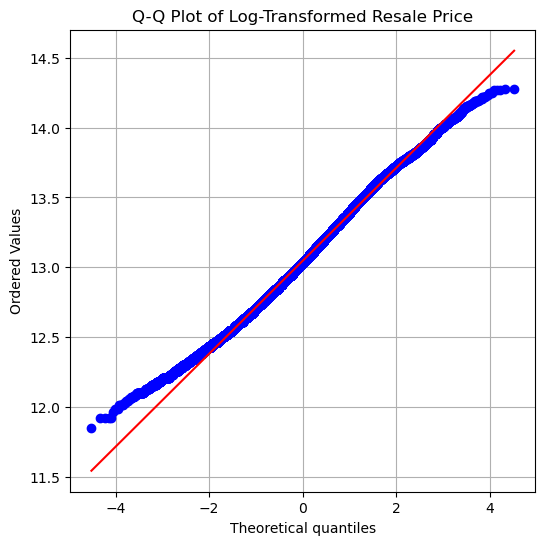

In [ ]:
import scipy.stats as stats

# 10. Histogram + Density plot of resale_price
plt.figure(figsize=(10, 5))
sns.histplot(df["resale_price"], bins=60, kde=True, color="skyblue", stat="density", edgecolor="white")
plt.title("Distribution of Resale Price")
plt.xlabel("Resale Price (SGD)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# Histogram + Density plot of log(resale_price)
plt.figure(figsize=(10, 5))
sns.histplot(np.log(df["resale_price"]), bins=60, kde=True, color="lightblue", stat="density", edgecolor="white")
plt.title("Distribution of Log-Transformed Resale Price")
plt.xlabel("log(Resale Price)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# Q-Q plot for original resale_price
plt.figure(figsize=(6, 6))
stats.probplot(df["resale_price"].dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Resale Price")
plt.grid()
plt.show()

# Q-Q plot for log-transformed resale_price
plt.figure(figsize=(6, 6))
stats.probplot(np.log(df["resale_price"].dropna()), dist="norm", plot=plt)
plt.title("Q-Q Plot of Log-Transformed Resale Price")
plt.grid()
plt.show()

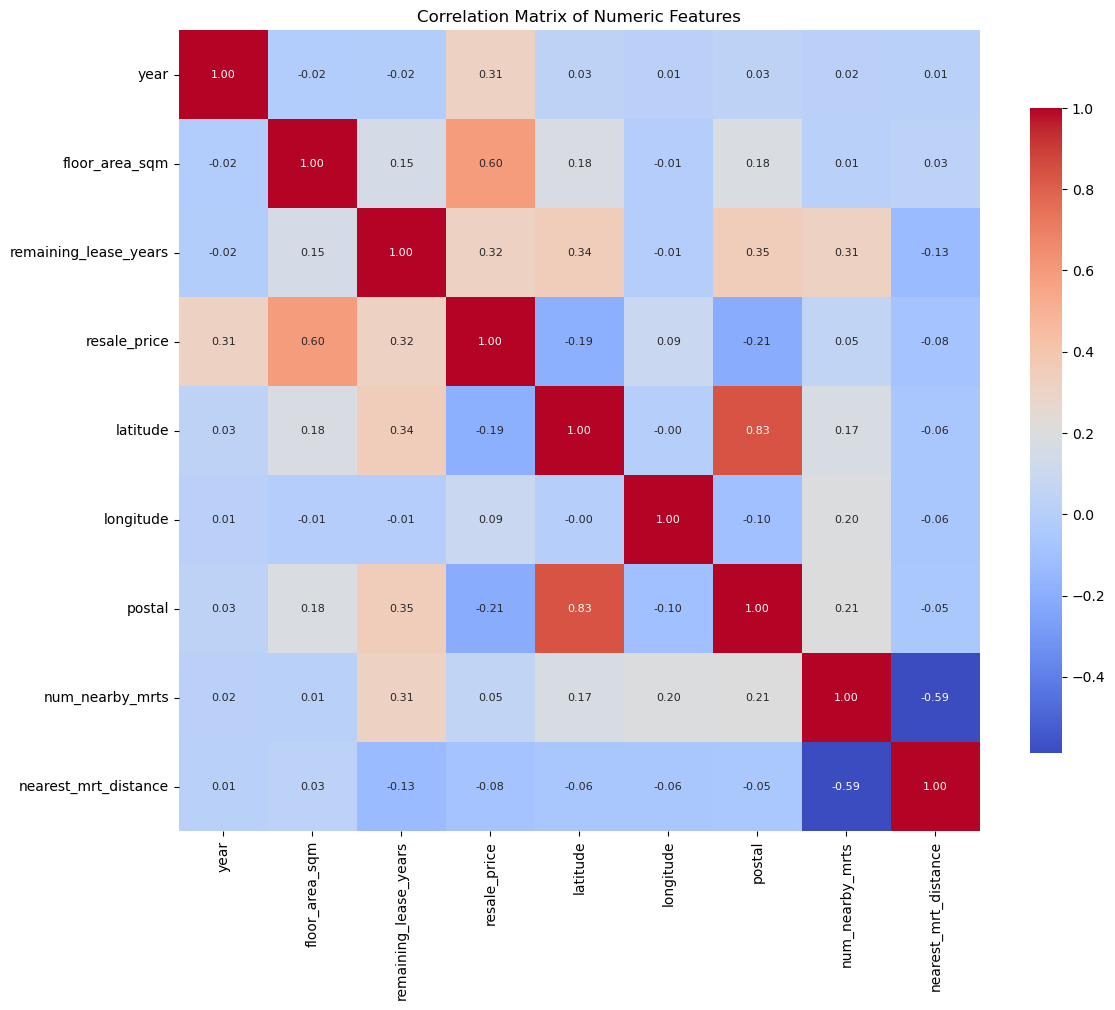

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 11. Compute and plot correlation matrix for numeric columns
numeric_df = df.select_dtypes(include=[np.number]) 
cor_matrix = numeric_df.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"shrink": .8}, annot_kws={"size": 8})
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

In [ ]:
# Count and filter street_name with at least 100 observations
street_counts = df['street_name'].value_counts()

# Filter to keep only street names with at least 100 observations
valid_streets = street_counts[street_counts >= 100].index.tolist()

# Filter the dataframe
df = df[df['street_name'].isin(valid_streets)]

# Number of unique streets remaining
num_unique_streets = df['street_name'].nunique()
print("Number of unique streets with at least 100 entries:", num_unique_streets)

Number of unique streets with at least 100 entries: 439
